In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data.sampler as sampler

import os
import fnmatch
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.optim import lr_scheduler

# import timm


from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import time
import json


# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL
b_ = Fore.BLUE

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# Hyperparameters
cfg = {
    "in_channels" :3,
    "num_classes": 1,
    "learning_rate" : 0.001,
    "batch_size" : 8,
    "num_epochs" : 40,
    "n_accumulate": 1,
    "competition": "FYP Depth Estimation",
    "model_name": "unet_scratch",
    "min_lr": 1e-6,
    "T_max": 500,
    "T_0": 50
}

cfg["learning_rate"] = 1e-3
cfg["optimizer"] = "Adam-default"
cfg["criterion"] = "MSELoss"
cfg["img-size"] = (128, 256, 3)
cfg["depth-map-size"] = (128, 256, 1)
cfg["batch_size"] = 16
cfg["lr scheduler"] = True
cfg["scheduler"] = "CosineAnnealingWarmRestarts" # CosineAnnealingWarmRestarts
cfg["model_dir"] = cfg["model_name"]+"_weights"
CONFIG = cfg
    
with open("config.json", "w") as outfile:
    json.dump(cfg, outfile)

In [4]:
# Import Config
pd.set_option('display.max_colwidth', None)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model directory
os.makedirs(cfg["model_dir"])

In [5]:
content = ""
for i in cfg.keys():
    content += i+"-"+str(cfg[i])+","
content

'in_channels-3,num_classes-1,learning_rate-0.001,batch_size-16,num_epochs-40,n_accumulate-1,competition-FYP Depth Estimation,model_name-unet_scratch,min_lr-1e-06,T_max-500,T_0-50,optimizer-Adam-default,criterion-MSELoss,img-size-(128, 256, 3),depth-map-size-(128, 256, 1),lr scheduler-True,scheduler-CosineAnnealingWarmRestarts,model_dir-unet_scratch_weights,'

# wandb

In [6]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')
# wandb.init(project="PogChamp2 Baseline")
run = wandb.init(project=CONFIG['competition'], 
                 config=CONFIG,
                 job_type='Train',
                 tags=['depth estimation', CONFIG['model_name']],
                 anonymous='must',
                 name = "unet scratch [w/ Lr sched](main: 2)",
                 notes = "minor fixes: dataloader viz, inference viz, result.csv fix")
       
# wandb.finish()

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# dataset

In [7]:
class CityScapes(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
#         semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))
        
        return image.float(), depth.float()

    def __len__(self):
        return self.data_len

In [8]:
dataset_path = '../input/cityscapes-depth-and-segmentation/data'
train_set = CityScapes(root=dataset_path, train=True)
test_set = CityScapes(root=dataset_path, train=False)

In [9]:
img,depth = train_set[0]
img.shape,depth.shape

(torch.Size([3, 128, 256]), torch.Size([1, 128, 256]))

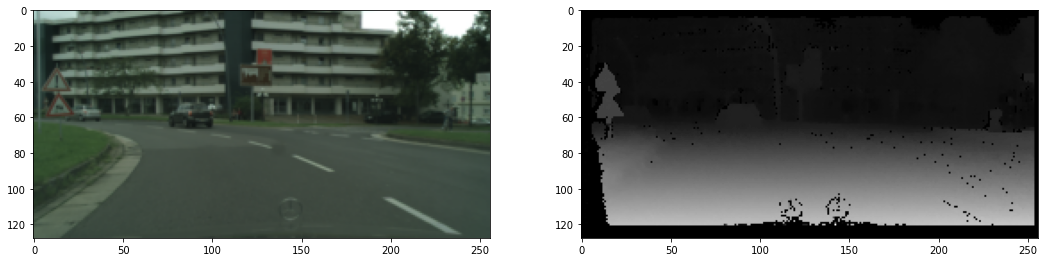

In [10]:
img_np = img.permute(1,2,0).detach().numpy()

depth_np = depth.permute(1,2,0).reshape((128,256)).detach().numpy()
plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
plt.imshow(img_np)

plt.subplot(1,2,2)
plt.imshow(depth_np,cmap="gray")

In [11]:
def props(img,show_uniques=True):
    print("Shape :",img.shape,"Maximum :",img.max(),"Minimum :",img.min(),"Data Type :",img.dtype)
    if show_uniques:
        print("Uniques :",np.unique(img))
        
props(depth,False)

Shape : torch.Size([1, 128, 256]) Maximum : tensor(0.4734) Minimum : tensor(0.) Data Type : torch.float32


# Unet mode def

In [12]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)
#         self.linear = nn.Linear(256, 128*256)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
#         x = self.linear(x)
        
        return torch.sigmoid(x)

In [13]:
train_on_gpu = torch.cuda.is_available()
model = UNet(n_channels=cfg["in_channels"], n_classes=cfg["num_classes"]).float()
if train_on_gpu:
    model.cuda()

In [14]:
# train_on_gpu = torch.cuda.is_available()
# model1 = UNet_depth(n_channels=cfg["in_channels"], n_classes=cfg["num_classes"]).float()
# if train_on_gpu:
#     model1.cuda()

In [15]:
# model(torch.randn(2,3,256,256).cuda()).shape

In [16]:
model(torch.randn(2,3,256,256).cuda()).shape

torch.Size([2, 1, 256, 256])

In [17]:
# batch_size = 8
train_loader = torch.utils.data.DataLoader(
               dataset=train_set,
               batch_size=cfg["batch_size"],
               shuffle=False,
               num_workers=2)

test_loader = torch.utils.data.DataLoader(
              dataset=test_set,
              batch_size=cfg["batch_size"],
              shuffle=False,
              num_workers=2)


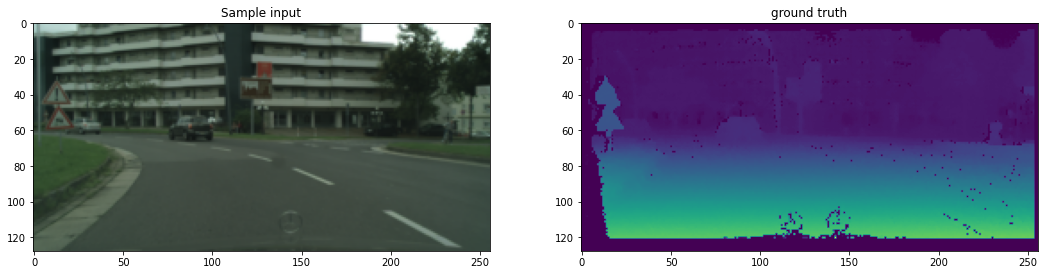

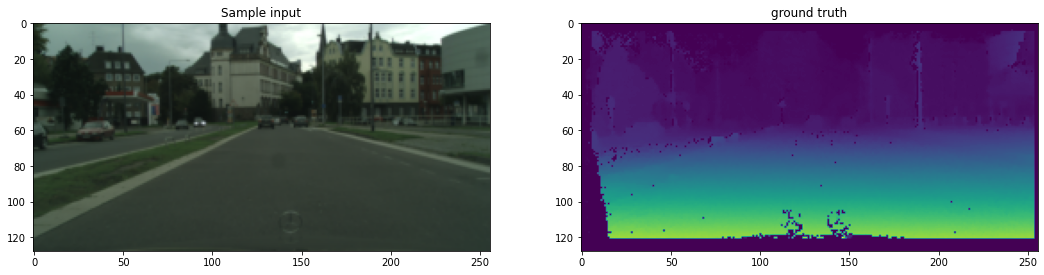

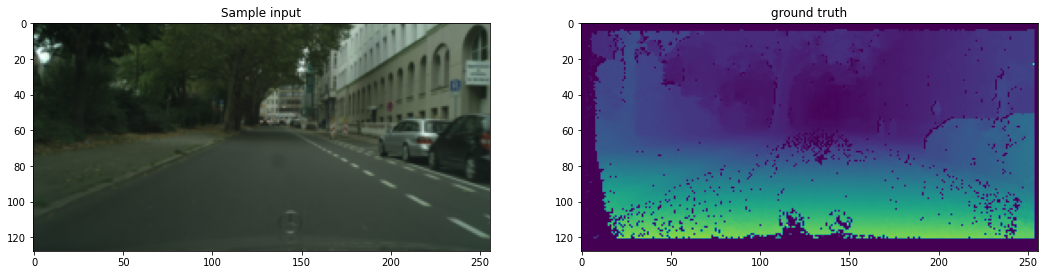

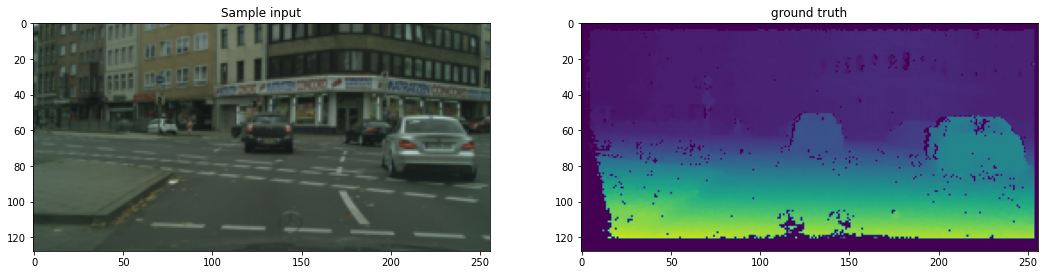

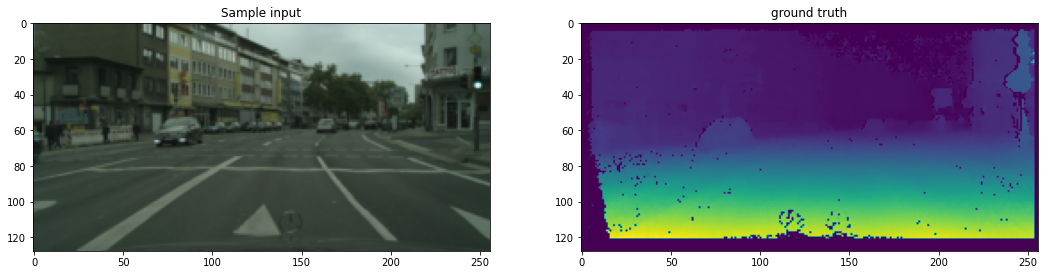

In [18]:
ip_img = next(iter(train_loader))[0][0:5]
ip_deph = next(iter(train_loader))[1][0:5]

for i, j in zip(ip_img,ip_deph):
    plt.figure(figsize=(18,18))
    plt.subplot(1,2,1)
    plt.imshow(i.permute(1, 2, 0))
    plt.title("Sample input")
    
    plt.subplot(1,2,2)
    plt.imshow(j.permute(1, 2, 0))
    plt.title("ground truth")
    

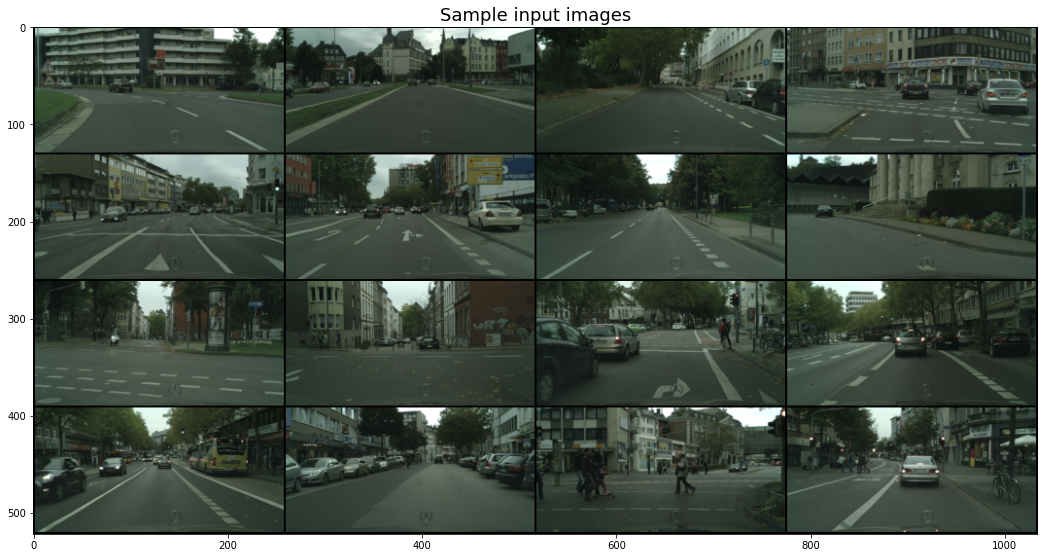

In [19]:
grid_img = torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=4)
plt.figure(figsize=(18,18))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Sample input images",fontsize=18);

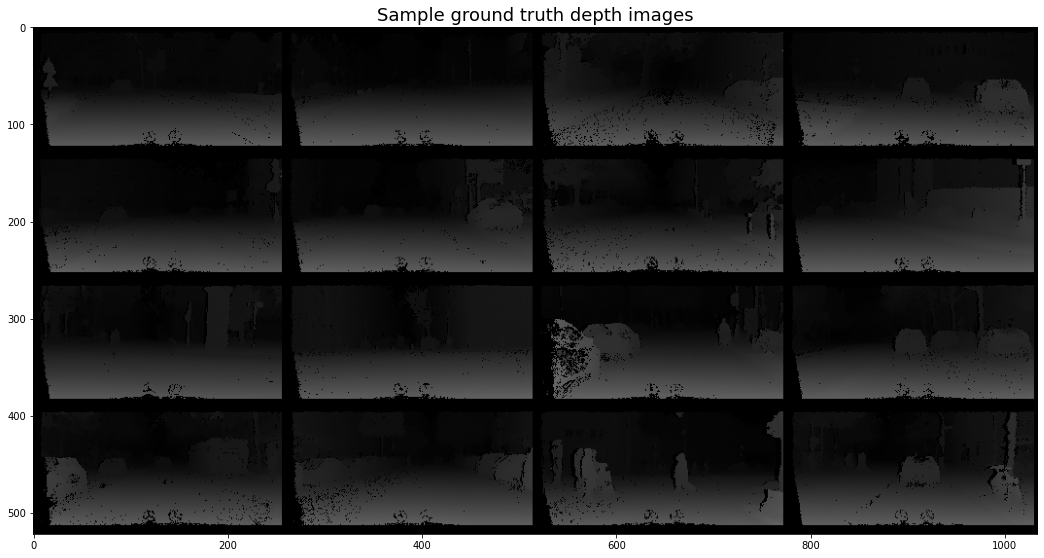

In [20]:
grid_dph = torchvision.utils.make_grid(next(iter(train_loader))[1], nrow=4)
plt.figure(figsize=(18,18))
plt.imshow(grid_dph.permute(1, 2, 0))
plt.title("Sample ground truth depth images",fontsize=18);

In [21]:
def save_model(epoch, model, model_file):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_file)

In [22]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=cfg["learning_rate"])
scheduler = fetch_scheduler(optimizer)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.4, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-7, eps=1e-08, verbose=True)

In [24]:
# from tqdm import tqdm
# # Train Network
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# total_epoch = 10
# for epoch in range(10):
#     print(f"============ starting epoch [{epoch+1}/{total_epoch}] ============")
#     running_loss = 0.0
    
    
#     for i, (data, targets) in enumerate(tqdm(train_loader)):
#         # Get data to cuda if possible
#         data = data.to(device=device)
#         targets = targets.to(device=device)
        
#         # forward
#         scores = model(data)
#         loss = criterion(scores, targets)  # CrossEntropyLoss accepts prediction in the shape of (64,10) and target is 64 [not sure]

#         # backward
#         optimizer.zero_grad()
#         loss.backward()

#         # gradient descent or adam step
#         optimizer.step()
        
#         running_loss += loss.item()

#         if i % 4 == 0:    # print every 4 mini-batches
# #             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             wandb.log({'epoch': epoch+1, 'loss': running_loss/2000})
#             running_loss = 0.0
        
#     print(f"total loss {running_loss}")
# #     print('Finished Training')
    
# #     save_model(epoch,model,f"cnn_adam_e{epoch}.pth")

In [25]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (data, targets) in bar:
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        batch_size = data.size(0)
        
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss = loss / cfg['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % cfg['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step() # set it to this if the scheduler is none scheduler.step()
                
#         running_loss += (loss.item() * batch_size)
        running_loss += loss.item()
#         epoch_loss = running_loss / dataset_size
        dataset_size += batch_size
        
        epoch_loss = running_loss / len(dataloader)
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [27]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    LABELS = []
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (data, targets) in bar:
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        batch_size = data.size(0)

        outputs = model(data)
#         _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(outputs.view(-1).cpu().detach().numpy())
        LABELS.append(targets.view(-1).cpu().detach().numpy())
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    LABELS = np.concatenate(LABELS)
    PREDS = np.concatenate(PREDS)
    val_mae = mean_absolute_error(LABELS, PREDS)
    val_mse = mean_squared_error(LABELS, PREDS)
    val_r2 = r2_score(LABELS, PREDS)

    print("val_mae", val_mae)
    print("val_mse", val_mse)
    print("val_r2", val_r2)
    
    
    gc.collect()
    
    return epoch_loss, val_mae, val_mse,val_r2

# train:

In [28]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter
def run_training(model, train_loader, valid_loader, optimizer, device, num_epochs, model_dir=None, scheduler=None):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_mae = float('inf')
    best_epoch_mse = float('inf')
    best_epoch_r2 = float('inf')
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        PATH = ""
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch)
        
        val_epoch_loss, val_epoch_mae, val_epoch_mse, val_epoch_r2 = valid_one_epoch(model, valid_loader, 
                                                       device=device, 
                                                       epoch=epoch)
    
        history['Train_Loss'].append(train_epoch_loss)
        history['Valid_Loss'].append(val_epoch_loss)
        history['Valid_mae'].append(val_epoch_mae)
        history['Valid_mse'].append(val_epoch_mse)
        history['Valid_r2'].append(val_epoch_r2)

        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid mae": val_epoch_mae})
        wandb.log({"Valid mse": val_epoch_mse})
        wandb.log({"Valid r2": val_epoch_r2})

        
        # deep copy the model
        if val_epoch_mae <= best_epoch_mae and val_epoch_mse <= best_epoch_mse:
            print(f"{b_}Validation mse Improved ({best_epoch_mse} ---> {val_epoch_mse})")
            best_epoch_mse = val_epoch_mse
            run.summary["Best mse Score"] = best_epoch_mse
            
            
            print(f"{b_}Validation mae Improved ({best_epoch_mae} ---> {val_epoch_mae})")
            best_epoch_mae = val_epoch_mae
            run.summary["Best mae Score"] = best_epoch_mae
            
            best_model_wts = copy.deepcopy(model.state_dict())
            
            PATH = cfg["model_dir"]+ "/" + "epoch{:.0f}_mae{:.4f}_mse{:.4f}.pth".format(epoch, best_epoch_mae,best_epoch_mse)
            
            save_model(epoch, model, PATH)
            history['model_path'].append(PATH)
#             print(f"Model Saved{sr_}")
        
        # deep copy the model
        elif val_epoch_mae <= best_epoch_mae and val_epoch_mse <= best_epoch_mse:
            print(f"{b_}Validation mae Improved ({best_epoch_mae} ---> {val_epoch_mae})")
            best_epoch_mae = val_epoch_mae
            run.summary["Best mae Score"] = best_epoch_mae
            best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = "F1{:.4f}_epoch{:.0f}.pth".format(best_epoch_mae, epoch)
            PATH = cfg["model_dir"]+ "/" + "epoch{:.0f}_mae{:.4f}_mse{:.4f}.pth".format(epoch, best_epoch_mae,best_epoch_mse)
            
            save_model(epoch, model, PATH)
            history['model_path'].append(PATH)
        
#             print(f"Model Saved{sr_}")
            
            
        # deep copy the model
        elif val_epoch_mse <= best_epoch_mse and val_epoch_mae <= best_epoch_mae:
            print(f"{b_}Validation mse Improved ({best_epoch_mse} ---> {val_epoch_mse})")
            best_epoch_mse = val_epochmse
            run.summary["Best mse Score"] = best_epoch_mse
            best_model_wts = copy.deepcopy(model.state_dict())
#             PATH = "F1{:.4f}_epoch{:.0f}.pth".format(best_epoch_mse, epoch)
            PATH = cfg["model_dir"]+ "/" + "epoch{:.0f}_mae{:.4f}_mse{:.4f}.pth".format(epoch, best_epoch_mae,best_epoch_mse)
            
            save_model(epoch, model, PATH)
            history['model_path'].append(PATH)
#             torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
#             print(f"Model Saved{sr_}")
        
        else:
            history['model_path'].append("not_saved")
        
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best mae: {:.4f}  || mse {:.4f} || r2 {:.4f} ||".format(best_epoch_mae, best_epoch_mse, max(history['Valid_r2'])))
    print(f"epoch: {history['Valid_r2'].index(max(history['Valid_r2']))}")
#     print()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# Metric check:

In [29]:
import copy
from collections import defaultdict
import gc

model, history = run_training(model,train_loader,
                              test_loader, optimizer,
                              device=device,
                              num_epochs=cfg["num_epochs"],
                              scheduler=scheduler,
                              model_dir = cfg["model_dir"]
                              ) # scheduler=scheduler

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 32/32 [00:05<00:00,  5.69it/s, Epoch=1, LR=0.000182, Valid_Loss=0.00593]


val_mae 0.056168817
val_mse 0.0059290887
val_r2 0.5380595053080458
Validation mse Improved (inf ---> 0.005929088685661554)
Validation mae Improved (inf ---> 0.0561688169836998)



100%|██████████| 32/32 [00:02<00:00, 11.25it/s, Epoch=2, LR=0.000594, Valid_Loss=0.00475]


val_mae 0.042979255
val_mse 0.0047517964
val_r2 0.6297834964687492
Validation mse Improved (0.005929088685661554 ---> 0.004751796368509531)
Validation mae Improved (0.0561688169836998 ---> 0.04297925531864166)



100%|██████████| 32/32 [00:02<00:00, 11.24it/s, Epoch=3, LR=0.000938, Valid_Loss=0.00442]


val_mae 0.040731467
val_mse 0.0044183307
val_r2 0.6557636137220977
Validation mse Improved (0.004751796368509531 ---> 0.004418330732733011)
Validation mae Improved (0.04297925531864166 ---> 0.04073146730661392)



100%|██████████| 32/32 [00:02<00:00, 11.32it/s, Epoch=4, LR=3.61e-5, Valid_Loss=0.00435]


val_mae 0.04049242
val_mse 0.0043481565
val_r2 0.6612309562152197
Validation mse Improved (0.004418330732733011 ---> 0.0043481565080583096)
Validation mae Improved (0.04073146730661392 ---> 0.04049241915345192)



100%|██████████| 32/32 [00:03<00:00, 10.65it/s, Epoch=5, LR=0.000346, Valid_Loss=0.00431]


val_mae 0.039296046
val_mse 0.0043139006
val_r2 0.6639003922263874
Validation mse Improved (0.0043481565080583096 ---> 0.004313900601118803)
Validation mae Improved (0.04049241915345192 ---> 0.039296045899391174)



100%|██████████| 32/32 [00:02<00:00, 11.21it/s, Epoch=6, LR=0.000768, Valid_Loss=0.00424]


val_mae 0.039084006
val_mse 0.004242501
val_r2 0.6694629521408972
Validation mse Improved (0.004313900601118803 ---> 0.004242501221597195)
Validation mae Improved (0.039296045899391174 ---> 0.03908400610089302)



100%|██████████| 32/32 [00:02<00:00, 11.30it/s, Epoch=7, LR=0.000996, Valid_Loss=0.00413]


val_mae 0.03881906
val_mse 0.004128782
val_r2 0.6783230395713477
Validation mse Improved (0.004242501221597195 ---> 0.004128782078623772)
Validation mae Improved (0.03908400610089302 ---> 0.03881905972957611)



100%|██████████| 32/32 [00:02<00:00, 11.34it/s, Epoch=8, LR=0.000136, Valid_Loss=0.0042]


val_mae 0.03857697
val_mse 0.0041982587
val_r2 0.6729100675836535



100%|██████████| 32/32 [00:02<00:00, 10.97it/s, Epoch=9, LR=0.000532, Valid_Loss=0.00402]


val_mae 0.03609077
val_mse 0.0040239496
val_r2 0.6864905802536383
Validation mse Improved (0.004128782078623772 ---> 0.0040239496156573296)
Validation mae Improved (0.03881905972957611 ---> 0.03609076887369156)



100%|██████████| 32/32 [00:03<00:00, 10.11it/s, Epoch=10, LR=0.000905, Valid_Loss=0.00406]


val_mae 0.037028443
val_mse 0.00405609
val_r2 0.6839864346465522



100%|██████████| 32/32 [00:02<00:00, 10.85it/s, Epoch=11, LR=1.67e-5, Valid_Loss=0.00393]


val_mae 0.037415396
val_mse 0.003933986
val_r2 0.6934995197213644



100%|██████████| 32/32 [00:02<00:00, 11.17it/s, Epoch=12, LR=0.000288, Valid_Loss=0.00411]


val_mae 0.035913434
val_mse 0.004107906
val_r2 0.6799495549708783



100%|██████████| 32/32 [00:02<00:00, 11.21it/s, Epoch=13, LR=0.000713, Valid_Loss=0.00443]


val_mae 0.03968584
val_mse 0.004433079
val_r2 0.6546150923684515



100%|██████████| 32/32 [00:03<00:00, 10.58it/s, Epoch=14, LR=0.000984, Valid_Loss=0.00378]


val_mae 0.034576103
val_mse 0.0037751058
val_r2 0.7058779182686841
Validation mse Improved (0.0040239496156573296 ---> 0.0037751058116555214)
Validation mae Improved (0.03609076887369156 ---> 0.03457610309123993)



100%|██████████| 32/32 [00:03<00:00,  9.39it/s, Epoch=15, LR=9.64e-5, Valid_Loss=0.00402]


val_mae 0.03539956
val_mse 0.004019161
val_r2 0.6868637214089295



100%|██████████| 32/32 [00:02<00:00, 11.25it/s, Epoch=16, LR=0.000469, Valid_Loss=0.00428]


val_mae 0.035613645
val_mse 0.0042831637
val_r2 0.666295174318815



100%|██████████| 32/32 [00:03<00:00, 10.40it/s, Epoch=17, LR=0.000865, Valid_Loss=0.00403]


val_mae 0.03780718
val_mse 0.004030042
val_r2 0.6860158331517943



100%|██████████| 32/32 [00:02<00:00, 10.73it/s, Epoch=18, LR=4.94e-6, Valid_Loss=0.00366]


val_mae 0.033947844
val_mse 0.003655588
val_r2 0.7151898989039206
Validation mse Improved (0.0037751058116555214 ---> 0.0036555880215018988)
Validation mae Improved (0.03457610309123993 ---> 0.03394784405827522)



100%|██████████| 32/32 [00:03<00:00, 10.39it/s, Epoch=19, LR=0.000233, Valid_Loss=0.00413]


val_mae 0.034426942
val_mse 0.004131614
val_r2 0.6781021957536513



100%|██████████| 32/32 [00:02<00:00, 10.67it/s, Epoch=20, LR=0.000655, Valid_Loss=0.00418]


val_mae 0.034428015
val_mse 0.0041835355
val_r2 0.6740571319734292



100%|██████████| 32/32 [00:03<00:00, 10.27it/s, Epoch=21, LR=0.000965, Valid_Loss=0.00381]


val_mae 0.033920415
val_mse 0.0038095224
val_r2 0.7031967117097022



100%|██████████| 32/32 [00:03<00:00, 10.16it/s, Epoch=22, LR=6.28e-5, Valid_Loss=0.00362]


val_mae 0.031777825
val_mse 0.0036198571
val_r2 0.7179736539777125
Validation mse Improved (0.0036555880215018988 ---> 0.003619857132434845)
Validation mae Improved (0.03394784405827522 ---> 0.03177782520651817)



100%|██████████| 32/32 [00:02<00:00, 10.98it/s, Epoch=23, LR=0.000407, Valid_Loss=0.00391]


val_mae 0.032413907
val_mse 0.00391298
val_r2 0.6951360502697088



100%|██████████| 32/32 [00:03<00:00, 10.33it/s, Epoch=24, LR=0.000819, Valid_Loss=0.0038]


val_mae 0.032835357
val_mse 0.0037961833
val_r2 0.7042357737692893



100%|██████████| 32/32 [00:02<00:00, 11.28it/s, Epoch=25, LR=0.001, Valid_Loss=0.00335]


val_mae 0.031949356
val_mse 0.0033509573
val_r2 0.7389242859565679



100%|██████████| 32/32 [00:03<00:00,  9.47it/s, Epoch=26, LR=0.000182, Valid_Loss=0.00377]


val_mae 0.032882392
val_mse 0.0037702122
val_r2 0.7062594260289159



100%|██████████| 32/32 [00:03<00:00, 10.29it/s, Epoch=27, LR=0.000594, Valid_Loss=0.00405]


val_mae 0.03198459
val_mse 0.0040460746
val_r2 0.6847670079066793



100%|██████████| 32/32 [00:02<00:00, 10.91it/s, Epoch=28, LR=0.000938, Valid_Loss=0.00329]


val_mae 0.02938204
val_mse 0.0032933145
val_r2 0.7434148693471588
Validation mse Improved (0.003619857132434845 ---> 0.0032933144830167294)
Validation mae Improved (0.03177782520651817 ---> 0.029382040724158287)



100%|██████████| 32/32 [00:03<00:00,  8.64it/s, Epoch=29, LR=3.61e-5, Valid_Loss=0.00324]


val_mae 0.030410206
val_mse 0.003243998
val_r2 0.7472575653957794



100%|██████████| 32/32 [00:03<00:00, 10.43it/s, Epoch=30, LR=0.000346, Valid_Loss=0.00349]


val_mae 0.030180855
val_mse 0.0034872317
val_r2 0.7283071411461167



100%|██████████| 32/32 [00:02<00:00, 11.26it/s, Epoch=31, LR=0.000768, Valid_Loss=0.00297]


val_mae 0.027939882
val_mse 0.0029738818
val_r2 0.7683023541083813
Validation mse Improved (0.0032933144830167294 ---> 0.002973881782963872)
Validation mae Improved (0.029382040724158287 ---> 0.02793988212943077)



100%|██████████| 32/32 [00:02<00:00, 11.18it/s, Epoch=32, LR=0.000996, Valid_Loss=0.00295]


val_mae 0.028454714
val_mse 0.002952068
val_r2 0.7700017893695796



100%|██████████| 32/32 [00:02<00:00, 11.19it/s, Epoch=33, LR=0.000136, Valid_Loss=0.00313]


val_mae 0.02936437
val_mse 0.0031266222
val_r2 0.7564018679618987



100%|██████████| 32/32 [00:02<00:00, 11.23it/s, Epoch=34, LR=0.000532, Valid_Loss=0.00341]


val_mae 0.027979836
val_mse 0.0034135114
val_r2 0.7340505478992533



100%|██████████| 32/32 [00:02<00:00, 11.05it/s, Epoch=35, LR=0.000905, Valid_Loss=0.0028]


val_mae 0.026514713
val_mse 0.0027962965
val_r2 0.7821382708087655
Validation mse Improved (0.002973881782963872 ---> 0.0027962964959442616)
Validation mae Improved (0.02793988212943077 ---> 0.02651471272110939)



100%|██████████| 32/32 [00:02<00:00, 11.22it/s, Epoch=36, LR=1.67e-5, Valid_Loss=0.00286]


val_mae 0.026721546
val_mse 0.002855536
val_r2 0.7775228234566608



100%|██████████| 32/32 [00:02<00:00, 11.20it/s, Epoch=37, LR=0.000288, Valid_Loss=0.00297]


val_mae 0.02615117
val_mse 0.0029699118
val_r2 0.768611597358154



100%|██████████| 32/32 [00:02<00:00, 11.29it/s, Epoch=38, LR=0.000713, Valid_Loss=0.00276]


val_mae 0.025820997
val_mse 0.0027641973
val_r2 0.784639061019166
Validation mse Improved (0.0027962964959442616 ---> 0.002764197299256921)
Validation mae Improved (0.02651471272110939 ---> 0.02582099661231041)



100%|██████████| 32/32 [00:02<00:00, 11.22it/s, Epoch=39, LR=0.000984, Valid_Loss=0.00251]


val_mae 0.024856534
val_mse 0.0025077297
val_r2 0.8046206052540872
Validation mse Improved (0.002764197299256921 ---> 0.0025077296886593103)
Validation mae Improved (0.02582099661231041 ---> 0.024856533855199814)



100%|██████████| 32/32 [00:02<00:00, 11.27it/s, Epoch=40, LR=9.64e-5, Valid_Loss=0.00286]


val_mae 0.025841491
val_mse 0.0028641357
val_r2 0.7768528388139804

Training complete in 0h 59m 1s
Best mae: 0.0249  || mse 0.0025 || r2 0.8046 ||
epoch: 38


In [30]:
# history

In [31]:
results_df = pd.DataFrame(history)
results_df.to_csv("results.csv")

# Inference:

In [32]:
best_model_path = results_df["model_path"].iloc[list(results_df["Valid_r2"]).index(max(results_df["Valid_r2"]))]
print("model path: ", best_model_path)
train_on_gpu = torch.cuda.is_available()
Model = UNet(n_channels=cfg["in_channels"], n_classes=cfg["num_classes"]).float()
if train_on_gpu:
    Model.cuda()
    
Model.load_state_dict(torch.load(best_model_path)['model_state_dict'])

model path:  unet_scratch_weights/epoch39_mae0.0249_mse0.0025.pth


<All keys matched successfully>

In [33]:
# train_on_gpu = torch.cuda.is_available()
# Model = UNet(n_channels=cfg["in_channels"], n_classes=cfg["num_classes"]).float()
# if train_on_gpu:
#     Model.cuda()

In [34]:
# Model.load_state_dict(torch.load("../input/unet-scratch-depth-estimation-1/mae0.1127_mse0.0255_epoch38.pth")['model_state_dict'])

In [35]:
def plot_infr(img,pred_img,gt_img,num):
    plt.figure(figsize=(18,18))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(f"Image index {num}-> | Input Image |")
    
    plt.subplot(1,3,2)
    plt.imshow(pred_img)
    plt.title(" | Predicted depth |")
    
    plt.subplot(1,3,3)
    plt.imshow(gt_img)
    plt.title("| Ground truth depth |")
    
    fname = "image"+str(num)+".png"
    plt.savefig(fname)

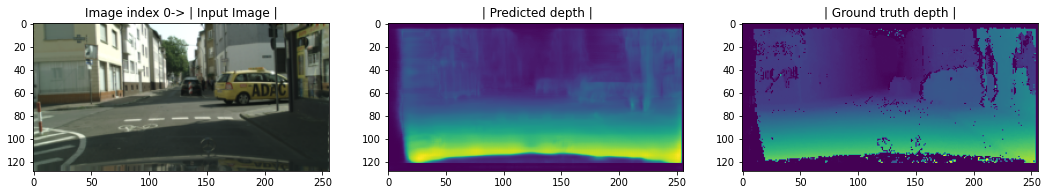

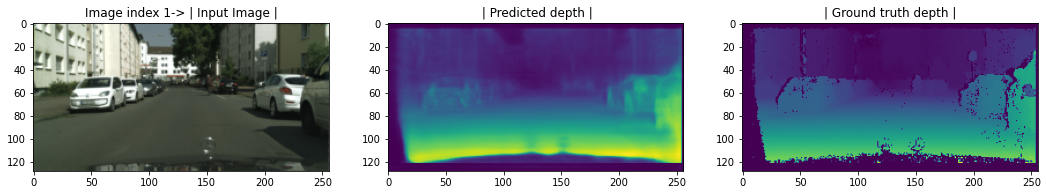

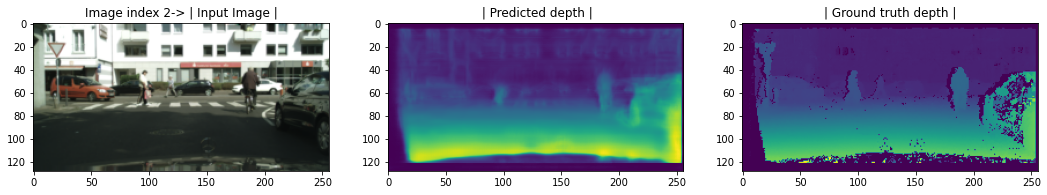

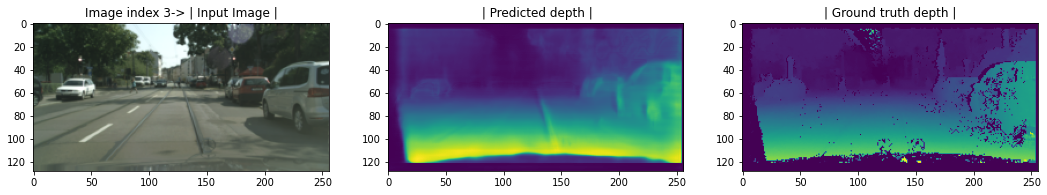

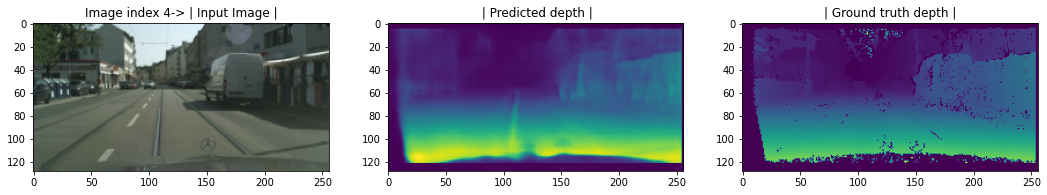

In [36]:
for i in range(5):
    pic,dep = test_set[i]
    pred = model(pic.unsqueeze(dim=0).cuda()).squeeze(dim=0).reshape((128, 256)).cpu().detach().numpy()
    gt = dep.permute(1,2,0).detach().numpy()
    pic = pic.permute(1,2,0).detach().numpy()
#     print(pic.shape,gt.shape,pred.shape)
#     break
    plot_infr(pic,pred,gt,i)

In [37]:
import glob
for i in glob.glob("./*.png"):
    wandb.save(i)


In [38]:
wandb.save("./config.json")
wandb.save("results.csv")

['/kaggle/working/wandb/run-20220404_052722-29uiot1l/files/results.csv']